# Notebook on Region Graphs


## Goals
By the end of this tutorial you will:

* [know what a region graph is](#What-is-a-Region-Graph?)
* know how to choose between region graphs for your circuit
* build circuits to **tractably** estimate a probability distribution over images[<sup>1</sup>](#fn1)

We will cover:

* High-level explanation of how to use region graphs
* Deep dive into region graphs (Advanced)


# How to build your circuit

In order to build a circuit, we need three main ingredients:

1. A **region graph**
2. A **parametrisation**
3. **folding**


## Why do we need these ingredients?

We need these ingredients becase we want to build **tractable/efficient** models that are **expressive**.

### 1. Region Graph

The structure of the region graph is what determines if inference can be efficient or not.
More specifically, we will introduce:

* RND
* QT
* QG


### 2. (Over)Parametrisation

Given a **region graph**, the simplest way to build a circuit is to associate a single input distribution unit per leaf
region, a single sum per inner region, and an single product unit per partition, and then connect them
following the RG structure.
If we parametrise a circuit simply, we do not get much expressive power.

### 3. Folding

If we naively compute a forward pass of a circuit, we need to resort to a lot of sparse computations.
But sparse compute is not compatible with GPUs.
However, in many case we can ``fold'' the computations into tensor operation via a process we call folding.
This operation does not affect the efficiency of the circuit in terms of big-oh notation, but it can significantly speed up inference empirically.
Note that folding is only a syntactic transformation of the circuit, i.e., it does not change the encoded function and
hence it preserves its expressiveness. 



[<sup id="fn1">1</sup>](#fn1-back)  This is not tractable for general neural network models



# Data Setup

As with the [previous tutorial](https://github.com/april-tools/cirkit/blob/main/notebooks/learning-a-circuit.ipynb), we will be working on the MNIST Dataset, so we begin by loading that:

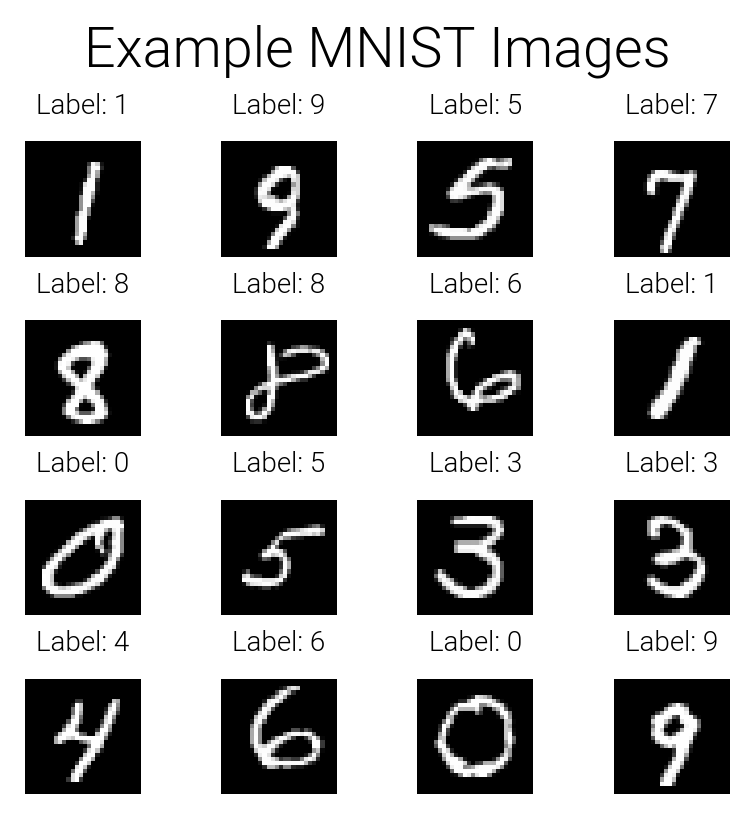

In [1]:
import matplotlib.pyplot as plt

from torch import optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

PIXEL_RANGE=255
# Store an example image
example_image = None

# Load the MNIST data set and data loaders
transform = transforms.Compose([
    transforms.ToTensor(),
    # Set pixel values in the [0-255] range
    transforms.Lambda(lambda x: (PIXEL_RANGE * x).long())
])

# Function to plot the first 9 images from the dataloader
def plot_sample_images(dataloader, gridsize=4):
    global example_image
    # Get the first batch of images and labels
    images, labels = next(iter(dataloader))
    
    example_image = images[0]
    images = images[:gridsize**2]
    
    # Create a 3x3 subplot
    fig, axes = plt.subplots(gridsize, gridsize, figsize=(8, 8))
    
    # Plot each image
    for i, ax in enumerate(axes.flat):
        # Convert the image to a 2D array (since MNIST images are 28x28 pixels)
        img = images[i].numpy().squeeze()

        # Display the image
        ax.imshow(img, cmap='gray')
        ax.axis('off')  # Turn off axis
        ax.set_title(f"Label: {labels[i].item()}", fontsize=20)
    
    # Adjust spacing between subplots
    fig.suptitle('Example MNIST Images')
    plt.tight_layout()
    plt.show()


data_train = datasets.MNIST('datasets', train=True, download=True, transform=transform)
data_test = datasets.MNIST('datasets', train=False, download=True, transform=transform)

# Instantiate the training and testing data loaders
train_dataloader = DataLoader(data_train, shuffle=True, batch_size=256)
test_dataloader = DataLoader(data_test, shuffle=False, batch_size=256)

# Call the function to plot images
plot_sample_images(train_dataloader, gridsize=4)

# Regions Graphs: High Level


## What is a Region Graph?

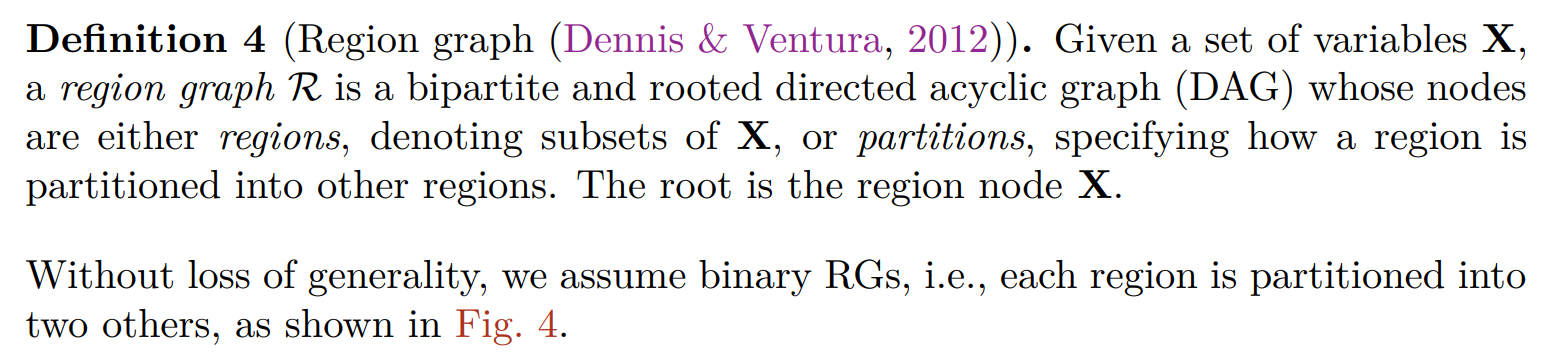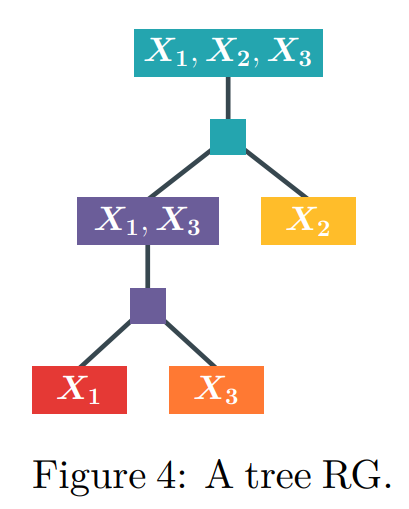

We begin with a high level overview of how to choose region graphs.
We begin where we left off in the [previous tutorial](https://github.com/april-tools/cirkit/blob/main/notebooks/learning-a-circuit.ipynb).
Recall we used:

```python
from cirkit.templates import circuit_templates

symbolic_circuit = circuit_templates.image_data(
    (1, 28, 28),                # The shape of MNIST image, i.e., (num_channels, image_height, image_width)
    # ----------------------------------------------------------------------------------------------------
    region_graph='quad-graph',  # Select the structure of the circuit to follow the QuadGraph region graph 
    # -----------------------------------------------------------------------------------------------------
    input_layer='categorical',  # Use Categorical distributions for the pixel values (0-255) as input layers
    num_input_units=64,         # Each input layer consists of 64 Categorical input units
    sum_product_layer='cp',     # Use CP sum-product layers, i.e., alternate dense sum layers and hadamard product layers
    num_sum_units=64,           # Each dense sum layer consists of 64 sum units
    sum_weight_param='softmax'  # Parameterize the weights of dense sum layers with 'softmax'
)
```

Here we dive into the `region_graph` line and explain the options we have.

In [2]:
NUM_INPUT_UNITS = 64
NUM_SUM_UNITS = 64

In [3]:
from cirkit.templates import circuit_templates


def define_circuit(region_graph):
    circuit = circuit_templates.image_data(
        (1, 28, 28),                # The shape of MNIST image, i.e., (num_channels, image_height, image_width)
        # ----------------------------------------------------------------------------------------------------
        region_graph=region_graph,  # Select the structure of the circuit to follow the QuadGraph region graph 
        # -----------------------------------------------------------------------------------------------------
        input_layer='categorical',  # Use Categorical distributions for the pixel values (0-255) as input layers
        num_input_units=NUM_INPUT_UNITS,         # Each input layer consists of 64 Categorical input units
        sum_product_layer='cp',     # Use CP sum-product layers, i.e., alternate dense sum layers and hadamard product layers
        num_sum_units=NUM_SUM_UNITS,           # Each dense sum layer consists of 64 sum units
        sum_weight_param='softmax'  # Parameterize the weights of dense sum layers with 'softmax'
    )
    return circuit

circuits = dict()
circuits['random-binary-tree'] = define_circuit('random-binary-tree')
circuits['quad-tree-2'] = define_circuit('quad-tree-2')
circuits['quad-graph'] = define_circuit('quad-graph')

# Region Graphs: Deep Dive

## Compute number of Random Variables

In [4]:
import numpy as np
# Compute number of random variables needed (one per pixel value)
img_shape = example_image.shape[1:]
n = np.prod(img_shape)

# Random Binary Tree

In [5]:
from cirkit.symbolic.circuit import Circuit
from cirkit.templates.region_graph import RandomBinaryTree
from cirkit.symbolic.layers import CategoricalLayer
from cirkit.templates.circuit_templates._factories import name_to_parameter_factory, name_to_initializer


def define_circuit_from_rg(rg):

    # Here is where Overparametrisation comes in
    input_factory = lambda x, y, z: CategoricalLayer(scope=x,
                                                     num_categories=PIXEL_RANGE+1,
                                                     num_channels=1, # These are grayscale images
                                                     num_output_units=NUM_INPUT_UNITS # No overparametrisation
                                                    )

    sum_weight_init = name_to_initializer('normal')
    sum_weight_params = name_to_parameter_factory('softmax', initializer=sum_weight_init)
    
    circuit = Circuit.from_region_graph(rg,
                                        input_factory=input_factory,
                                        sum_weight_factory= sum_weight_params,
                                        num_sum_units=NUM_SUM_UNITS,
                                        sum_product='cp')
    return circuit

# We can also specify depth and number of repetitions
# depth=None means maximum possible
rnd = RandomBinaryTree(n, depth=None)



circuits['random-binary-tree (from scratch)'] = define_circuit_from_rg(rnd)

# Quad Tree

In [6]:
from cirkit.templates.region_graph import QuadTree

qt = QuadTree(img_shape, num_patch_splits=2)
circuits['quad-tree-2 (from scratch)'] = define_circuit_from_rg(qt)

# Quad Graph

In [7]:
from cirkit.templates.region_graph import QuadGraph

qg = QuadGraph(img_shape)
circuits['quad-graph (from scratch)'] = define_circuit_from_rg(qg)

# Experiments: Comparison of Region Graphs

In [8]:
import random
import numpy as np
import torch

from cirkit.pipeline import compile


def train_circuit(cc):

    # Set some seeds
    random.seed(42)
    np.random.seed(42)
    torch.manual_seed(42)
    # torch.cuda.manual_seed(42)
    
    # Set the torch device to use
    device = torch.device('cuda')

    # Compile the circuit
    circuit = compile(cc)
    
    # Move the circuit to chosen device
    circuit = circuit.to(device)
    
    num_epochs = 5
    step_idx = 0
    running_loss = 0.0
    
    
    # Initialize a torch optimizer of your choice,
    #  e.g., Adam, by passing the parameters of the circuit
    optimizer = optim.Adam(circuit.parameters(), lr=0.01)
    
    for epoch_idx in range(num_epochs):
        for i, (batch, _) in enumerate(train_dataloader):
            # The circuit expects an input of shape (batch_dim, num_channels, num_variables),
            # so we unsqueeze a dimension for the channel.
            BS = batch.shape[0]
            batch = batch.view(BS, 1, -1).to(device)
    
            # Compute the log-likelihoods of the batch, by evaluating the circuit
            log_likelihoods = circuit(batch)
    
            # We take the negated average log-likelihood as loss
            loss = -torch.mean(log_likelihoods)
            loss.backward()
            # Update the parameters of the circuits, as any other model in PyTorch
            optimizer.step()
            optimizer.zero_grad()
            running_loss += loss.detach() * len(batch)
            step_idx += 1
            if step_idx % 100 == 0:
                print(f"Step {step_idx}: Average NLL: {running_loss / (100 * len(batch)):.3f}")
                running_loss = 0.0


for k, cc in circuits.items():
    print('\nTraining circuit with region graph "%s"' % k)
    cc = train_circuit(cc)


Training circuit with region graph "random-binary-tree"
Step 100: Average NLL: 3422.423
Step 200: Average NLL: 1614.733
Step 300: Average NLL: 1013.035
Step 400: Average NLL: 954.595
Step 500: Average NLL: 930.759
Step 600: Average NLL: 928.207
Step 700: Average NLL: 924.093
Step 800: Average NLL: 916.476
Step 900: Average NLL: 919.580
Step 1000: Average NLL: 911.700
Step 1100: Average NLL: 916.981

Training circuit with region graph "quad-tree-2"
Step 100: Average NLL: 3423.503
Step 200: Average NLL: 1599.988
Step 300: Average NLL: 951.543
Step 400: Average NLL: 851.868
Step 500: Average NLL: 802.758
Step 600: Average NLL: 779.314
Step 700: Average NLL: 761.668
Step 800: Average NLL: 743.466
Step 900: Average NLL: 737.404
Step 1000: Average NLL: 723.257
Step 1100: Average NLL: 722.298

Training circuit with region graph "quad-graph"
Step 100: Average NLL: 3413.503
Step 200: Average NLL: 1570.938
Step 300: Average NLL: 943.364
Step 400: Average NLL: 844.029
Step 500: Average NLL: 792.

## Further reading

For more details on region graphs, parametrisations and folding, see Chapters 4 and 5 of [What is the Relationship between Tensor Factorizations
and Circuits ](https://arxiv.org/abs/2409.07953).
For the implementations, see the code for the supported [Region Graphs](https://github.com/andreasgrv/cirkit/blob/main/cirkit/templates/region_graph/algorithms.py).


# Issues

* Creating circuit from region graph does not work unless I parametrise the sum layers - otherwise I get nan.
* There is a dead line of code in the image_data function:
  ```python
    sum_weight_init = "normal" if sum_weight_param == "softmax" else "uniform"
    initializer_kwargs = {"axis": -1} if sum_weight_init in {"dirichlet"} else {}   # <------ "dirichlet" never true
  ```
* Why does quad-tree and quad-graph not have `num_repetitions` attribute?

# Findings

* If we do not overaprametrise the inputs, all region graphs obtain equal log-likelihood.